In [1]:
import numpy as np
import plotly.graph_objects as go
import plotly.express as px

In [117]:
# Plot helpers
palette=[
    (48, 76, 137),
    (100, 141, 229),
    (158, 183, 229),
    (232, 229, 218),
    (205, 195, 146)
]

def cs(color, opacity=1):
    return f"rgba({','.join(str(c) for c in color)}, {opacity})"

In [266]:
# Transform helpers
def rotM(theta):
    theta = np.radians(theta)
    c, s = np.cos(theta), np.sin(theta)
    return np.array((
        (c, -s, 0), 
        (s, c, 0), 
        (0, 0, 1)
    ))

def transM(x, y):
    return np.array((
        (1, 0, x), 
        (0, 1, y), 
        (0, 0, 1)
    ))

def transform(m, v):
    v = [*v, 1]
    nv = m @ v
    return nv[:2]

def angle(v):
    return np.degrees(np.arctan2(v[1], v[0]))

In [299]:
# Components
def triangle(name, x, y, theta, side, corner, color, opacity=1):
    h = side * np.sqrt(3) / 2
    hc = corner * np.sqrt(3) / 2
    
    points = [
        (-side/2+corner, -h/3),
        (-side/2+corner/2, -h/3+hc),
        (0-corner/2, h*2/3-hc),
        (0+corner/2, h*2/3-hc),
        (side/2-corner/2, -h/3+hc),
        (side/2-corner, -h/3),
        (-side/2+corner, -h/3)
    ]
    
    points = np.array([transform(transM(x, y) @ rotM(theta), p) for p in points])
    
    return go.Scatter(
        x=points[:, 0],
        y=points[:, 1],
        mode='none',
        fill="toself",
        fillcolor=cs(color, opacity),
        name=name
    )

def box(name, x, y, theta, w, h, color, opacity=1):
    m = transM(x, y) @ rotM(theta)
    points = [(-w/2, -h/2), (-w/2, h/2), (w/2, h/2), (w/2, -h/2)]
    points = np.array([transform(m , p) for p in points])
    return go.Scatter(
        x=points[:, 0], 
        y=points[:, 1], 
        mode='none',
        fill="toself",
        fillcolor=cs(color, opacity),
        name=name
    )

In [380]:
class Robot:
    def __init__(
        self,
        base_side,
        base_corner,
        tool_side,
        tool_corner,
        outer_link_length,
        inner_link_length
    ):
        self.base_side = base_side
        self.base_corner = base_corner
        self.tool_side = tool_side
        self.tool_corner = tool_corner
        self.outer_link_length = outer_link_length
        self.inner_link_length = inner_link_length
        
        self.tool_x = 0
        self.tool_y = 0
        self.tool_theta = 0
        
        self.link_width = 8
    
    @property
    def corner_pos(self):
        return np.array((0, self.base_side / np.sqrt(3) - self.base_corner * np.sqrt(3) / 2))
    
    @property
    def motor_pos(self):
        v1 = self.corner_pos - np.array((0, self.base_corner * 1 / 3))
        return [
            transform(rotM(120*d), v1)
            for d in range(3)
        ]
    @property
    def tool_joint_pos(self):
        tool_corner = np.array((0, self.tool_side / np.sqrt(3) - self.tool_corner * np.sqrt(3) / 2))
        v1 = tool_corner - np.array((0, self.tool_corner))
        return [
            transform(transM(self.tool_x, self.tool_y) @ rotM(120 * i + self.tool_theta), v1)
            for i in range(3)
        ]
    
    @property
    def joint_coords(self):
        # Inverse kinematics
        
        mpos = self.motor_pos
        tjoint_pos = self.tool_joint_pos
        
        l1 = self.outer_link_length
        l2 = self.inner_link_length
        pvec = np.array([t-m for m, t in zip(mpos, tjoint_pos)])
        
        q = [
            np.degrees(np.arccos((np.dot(p, p) + l1**2-l2**2)/(2*l1*np.linalg.norm(p))))
            for p in pvec
        ]
        
        return q
        
    
    def set_tool_pos(self, x, y, theta):
        self.tool_x = x
        self.tool_y = y
        self.tool_theta = theta
        
    def render(self):
        base = triangle('Base', 0, 0, 0, self.base_side, self.base_corner, palette[0], 0.3)
        
        mpos = self.motor_pos
        mw = self.base_corner
        mh = 2*(self.corner_pos[1] - mpos[0][1]) - 5
        motors = [
            box(
                f"Motor {i+1}",
                *p,
                120 * i, 
                mw, mh, 
                palette[1],
                0.5
            ) for i, p in enumerate(mpos)
        ]
        
        motor_shafts = [
            go.Scatter(
                x=[p[0]], 
                y=[p[1]],
                marker=dict(
                    color='black'
                ),
                showlegend=False
            ) for p in mpos
        ]
        
        tjoint_pos = self.tool_joint_pos
        joint_coords = self.joint_coords
        
        link_joint_pos = [
            m + self.outer_link_length * (p := transform(rotM(q), t - m)) / np.linalg.norm(p)
            for m, t, q in zip(mpos, tjoint_pos, joint_coords)
        ]
        
        outer_link_pos = [
            (m + l) / 2
            for m, l in zip(mpos, link_joint_pos)
        ]
        
        outer_link_angles = [
            angle(l - m) + 90
            for m, l in zip(mpos, link_joint_pos)
        ]
        
        outer_links = [
            box(
                f"Outer Link {i+1}",
                *p[0],
                p[1],
                self.link_width, self.outer_link_length + self.link_width, 
                palette[3],
                0.8
            ) for i, p in enumerate(zip(outer_link_pos, outer_link_angles))
        ]
        
        link_joints = [
            go.Scatter(
                x=[p[0]], 
                y=[p[1]],
                marker=dict(
                    color='black'
                ),
                showlegend=False
            ) for p in link_joint_pos
        ]
        
        inner_link_pos = [
            (t + l) / 2
            for t, l in zip(tjoint_pos, link_joint_pos)
        ]
        
        inner_link_angles = [
            angle(t - l) + 90
            for t, l in zip(tjoint_pos, link_joint_pos)
        ]
        
        inner_links = [
            box(
                f"Inner Link {i+1}",
                *p[0],
                p[1],
                self.link_width, self.inner_link_length + self.link_width, 
                palette[4],
                0.8
            ) for i, p in enumerate(zip(inner_link_pos, inner_link_angles))
        ]
        
        tool = triangle('Tool', self.tool_x, self.tool_y, self.tool_theta, self.tool_side, self.tool_corner, palette[2], 1)
        
        tool_joints = [
            go.Scatter(
                x=[p[0]], 
                y=[p[1]],
                marker=dict(
                    color='black'
                ),
                showlegend=False
            ) for p in tjoint_pos
        ]
        
        tool_center = go.Scatter(
            x=[self.tool_x], 
            y=[self.tool_y],
            marker=dict(
                color=cs(palette[3])
            ),
            showlegend=False
        )
        
        return [
            base,
            tool,
            *tool_joints,
            *motors,
            *motor_shafts,
            *outer_links,
            *link_joints,
            *inner_links,
            tool_center
        ]

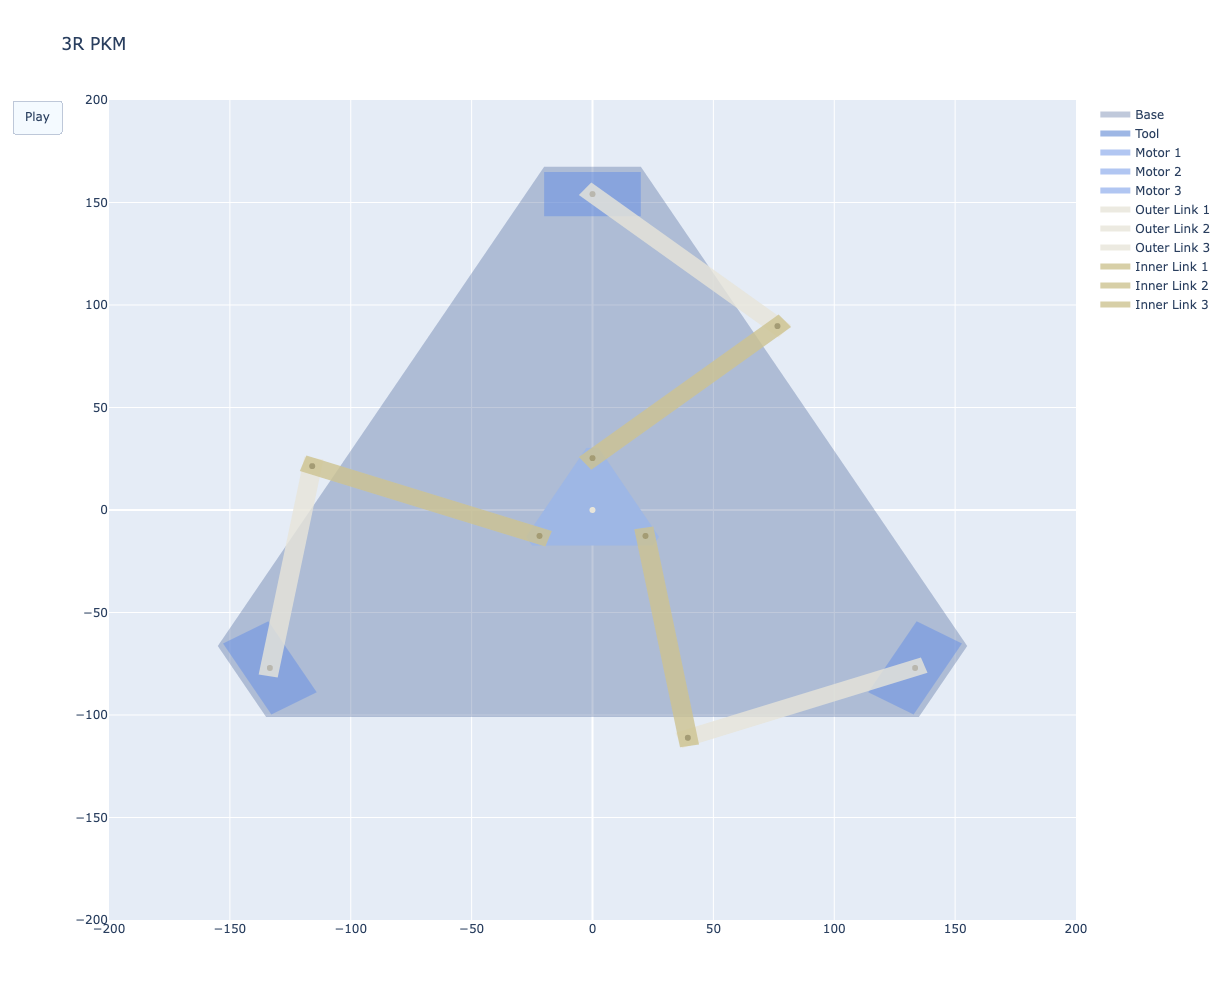

In [397]:
rb = Robot(
    base_side=350, 
    base_corner=40, 
    tool_side=60, 
    tool_corner=5, 
    outer_link_length=100, 
    inner_link_length=100
)

init_state = rb.render()

fps = 60
duration = 8

def cp(r, theta):
    return (r*np.cos(np.radians(theta)), r*np.sin(np.radians(theta)))

path = np.array((
    (0, 0, 0, 0),
    (0.125, 0, 0, 90),
    (0.25, 0, 60, -60),
    (0.375, 0, 0, 30),
    (0.5, 60, 0, 0),
    (0.53, *cp(60, 30), 0),
    (0.56, *cp(60, 60), 0),
    (0.59, *cp(60, 90), 0),
    (0.62, *cp(60, 120), 0),
    (0.65, *cp(60, 150), 0),
    (0.68, *cp(60, 180), 0),
    (0.71, *cp(60, 210), 0),
    (0.74, *cp(60, 240), 0),
    (0.77, *cp(60, 270), 0),
    (0.8, *cp(60, 300), 0),
    (0.83, *cp(60, 330), 0),
    (0.86, *cp(60, 0), 0),
    (1.0, 0, 0, 0)
))

frame_data = np.array([np.interp(np.linspace(0, 1, fps * duration), path[:, 0], path[:, i+1]) for i in range(3)]).T

frames = []
    
for fd in frame_data:
    x, y, theta = fd
    rb.set_tool_pos(x, y, theta)
    frames.append(go.Frame(data=rb.render()))
    

fig = go.Figure(
    data=init_state,
    layout=go.Layout(
        title="3R PKM",
        autosize=False,
        width=1000,
        height=1000,
        xaxis=dict(
            autorange=False,
            range=[-200, 200]
        ),
        yaxis=dict(
            autorange=False,
            range=[-200, 200]
        ),
        updatemenus=[dict(
            type="buttons",
            buttons=[dict(
                label="Play",
                method="animate",
                args = [None, {
                    "frame": {
                        "duration": 1000 // fps, 
                        "redraw": False},
                    "fromcurrent": True, 
                    "transition": {"duration": 0}}],
            )])]
    ),
    frames=frames
)

fig.show()